In [8]:
import sys
import os
import numpy as np
import pandas as pd
import pyarrow
import importlib
sys.path.append('G:\Farshid\CONUS_Temp\Example3')  ## HydroDL package
import pyarrow
import matplotlib.pyplot as plt
import torch

In [9]:
### creating ML model

import torch
from torch.autograd import Variable
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

In [10]:
### create data
####### Address of forcing pandas dataframe file ################
forcing_path = os.path.join('G:\Farshid\CONUS_Temp\Example3\scratch\\SNTemp\Forcing\Forcing_new\\no_dam_forcing_60%_days118sites.feather')
forcingT = pd.read_feather(forcing_path)
site_no = forcingT['site_no'].unique()

In [11]:
### our training and testing period
forcing = forcingT.loc[(forcingT['datetime']>='2010-10-01') & 
                       (forcingT['datetime']<'2016-10-01')]

In [12]:
forcing['tmean(C)'] = (((forcing['tmax(C)'] + forcing['tmin(C)'])/2).to_numpy())

C:\Users\fzr5082\.conda\envs\newenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
mean_tmax = np.mean(forcing.loc[:,'tmax(C)'])
std_tmax = np.std(forcing.loc[:,'tmax(C)'])
mean_tmin = np.mean(forcing.loc[:,'tmin(C)'])
std_tmin = np.std(forcing.loc[:,'tmin(C)'])
mean_tmean = np.mean(forcing.loc[:,'tmean(C)'])
std_tmean = np.std(forcing.loc[:,'tmean(C)'])
mean_Tsw = np.nanmean(forcing.loc[forcing['00010_Mean']>(-10),'00010_Mean'])
std_Tsw = np.nanstd(forcing.loc[forcing['00010_Mean']>(-10),'00010_Mean'])

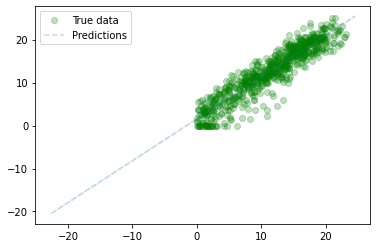

0


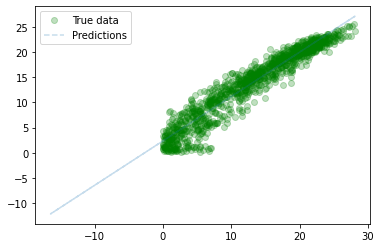

1


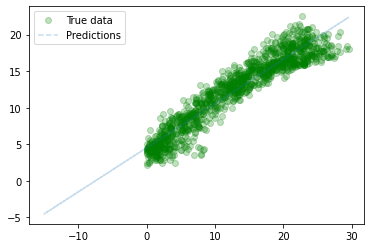

2


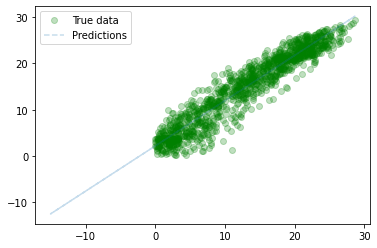

3


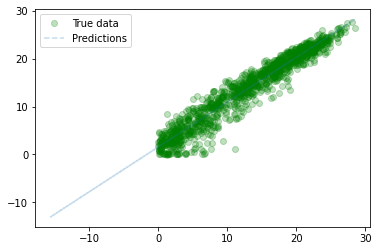

4


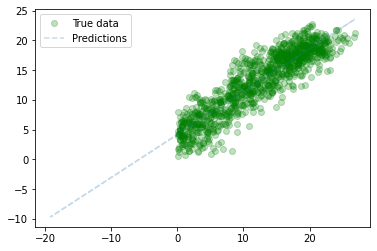

5


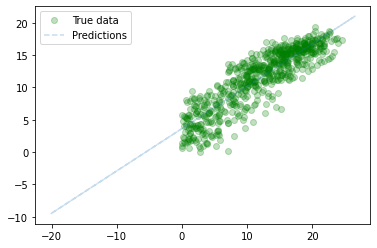

6


In [ ]:
ab = np.zeros((len(site_no),4))   # saves wieghts, bias, loss intraining, and loss in testing for each basin
pred_test = np.zeros((len(site_no),731))
pred_train = np.zeros((len(site_no),1461))
obs_train = np.zeros((len(site_no),1461))
airT = np.zeros((len(site_no),1461))
obs_test = np.zeros((len(site_no),731))

for j, jj in enumerate (site_no):

    t_start_train = '2010-10-01'
    t_end_train = '2014-10-01'
    t_start_test = '2014-10-01'
    t_end_test = '2016-10-01'
    tmax_train_T = forcing.loc[(forcing['datetime']>=t_start_train) &
                            (forcing['datetime']<t_end_train) & 
                            (forcing['site_no']==jj), 'tmax(C)'].to_numpy(dtype=np.float32)
    tmin_train_T = forcing.loc[(forcing['datetime']>=t_start_train) &
                            (forcing['datetime']<t_end_train) & 
                            (forcing['site_no']==jj), 'tmin(C)'].to_numpy(dtype=np.float32)
    Tsw_train_T = forcing.loc[(forcing['datetime']>=t_start_train) &
                            (forcing['datetime']<t_end_train) & 
                            (forcing['site_no']==jj), '00010_Mean'].to_numpy(dtype=np.float32)

    tmean_train_T = (tmax_train_T+tmin_train_T)/2
    
    nan_array = np.isnan(Tsw_train_T)
    not_nan_array = ~ nan_array
    Tsw_train = Tsw_train_T[not_nan_array]
    tmean_train = tmean_train_T[not_nan_array]
    mask = (tmean_train>=0)   # eliminating elements with air temperature less than zero
    Tsw_train = Tsw_train[mask]   # eliminating elements with air temperature less than zero
    tmean_train = tmean_train[mask]   # eliminating elements with air temperature less than zero
    
    #normalizing
    

    #print(Tsw_train[1])
    #print(Tsw_train_T[194])
    #print(tmax_train_T[194])
    #print(tmin_train_T[194])
    #print(tmean_train[1])

    tmax_test_T = forcing.loc[(forcing['datetime']>=t_start_test) &
                            (forcing['datetime']<t_end_test) & 
                            (forcing['site_no']==jj), 'tmax(C)'].to_numpy(dtype=np.float32)
    tmin_test_T = forcing.loc[(forcing['datetime']>=t_start_test) &
                            (forcing['datetime']<t_end_test) & 
                            (forcing['site_no']==jj), 'tmin(C)'].to_numpy(dtype=np.float32)
    Tsw_test_T = forcing.loc[(forcing['datetime']>=t_start_test) &
                            (forcing['datetime']<t_end_test) & 
                            (forcing['site_no']==jj), '00010_Mean'].to_numpy(dtype=np.float32)
    tmean_test_T = (tmax_test_T+tmin_test_T)/2
    nan_array = np.isnan(Tsw_test_T)
    not_nan_array = ~ nan_array
    Tsw_test = Tsw_test_T[not_nan_array]
    tmean_test = tmean_test_T[not_nan_array]
    mask_test = (tmean_test>=0)   # eliminating elements with air temperature less than zero
    Tsw_test = Tsw_test[mask_test]   # eliminating elements with air temperature less than zero
    tmean_test = tmean_test[mask_test]   # eliminating elements with air temperature less than zero
    
    #normalizing
    tmean_train = (tmean_train-mean_tmean)/std_tmean
    Tsw_train = (Tsw_train-mean_Tsw)/std_Tsw
    tmean_test = (tmean_test-mean_tmean)/std_tmean
    Tsw_test = (Tsw_test-mean_Tsw)/std_Tsw    
    tmean_test_T1 =  (tmean_test_T-mean_tmean)/std_tmean
    tmean_train_T = (tmean_train_T-mean_tmean)/std_tmean
    
    
    x_train = tmean_train.reshape(Tsw_train.shape[0],1)
    y_train = Tsw_train.reshape(Tsw_train.shape[0],1)
    x_test_T = tmean_test_T1.reshape(tmean_test_T1.shape[0],1)
    x_test = tmean_test.reshape(tmean_test.shape[0],1)
    y_test = Tsw_test.reshape(Tsw_test.shape[0],1)
    tmean_train_T = tmean_train_T.reshape(tmean_train_T.shape[0],1)
    
    # now we initiate model

    inputDim = 1        # takes variable 'x' 
    outputDim = 1       # takes variable 'y'
    learningRate = 0.003 
    epochs = 1000

    model = linearRegression(inputDim, outputDim)
    ##### For GPU #######
    if torch.cuda.is_available():
        model.cuda()

    # initiating loss and optimization function

    criterion = torch.nn.MSELoss() 
    optimizer = torch.optim.Adadelta(model.parameters())  #, lr=learningRate)

    ## training model

    for epoch in range(epochs):
        # Converting inputs and labels to Variable
        if torch.cuda.is_available():
            #inputs = Variable(torch.from_numpy(x_train).cuda())
            #labels = Variable(torch.from_numpy(y_train).cuda())
            inputs = torch.tensor(x_train, requires_grad=True).cuda()
            labels = torch.tensor(y_train, requires_grad=True).cuda()
        else:
           # inputs = Variable(torch.from_numpy(x_train))
           # labels = Variable(torch.from_numpy(y_train))
            inputs = torch.tensor(x_train, requires_grad=True)
            labels = torch.tensor(y_train, requires_grad=True)

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        outputs = model(inputs)

        # get loss for the predicted output
        loss = criterion(outputs, labels)
      ##  print(loss)
        # get gradients w.r.t to parameters
        loss.backward()

        # update parameters
        optimizer.step()

       ## print('epoch {}, loss {}'.format(epoch, loss.item()))

    ### testing model

    with torch.no_grad(): # we don't need gradients in the testing phase
        if torch.cuda.is_available():
            predicted = model(Variable(torch.from_numpy(x_test).cuda())).cpu().data.numpy()
            predicted_T = model(Variable(torch.from_numpy(x_test_T).cuda())).cpu().data.numpy()
            p_train = model(Variable(torch.from_numpy(tmean_train_T).cuda())).cpu().data.numpy()
        else:
            predicted = model(Variable(torch.from_numpy(x_test))).data.numpy()
            predicted_T = model(Variable(torch.from_numpy(x_test_T))).data.numpy()
            p_train = model(Variable(torch.from_numpy(tmean_train_T))).data.numpy()
        #print(predicted)
    
    #denormalizeing
    x_test = (x_test * std_tmean) + mean_tmean
    x_test_T = (x_test_T * std_tmean) + mean_tmean
    y_test = (y_test * std_Tsw) + mean_Tsw
    predicted = (predicted * std_Tsw) + mean_Tsw
    predicted_T = (predicted_T * std_Tsw) + mean_Tsw
    p_train = (p_train * std_Tsw) + mean_Tsw
    x_train = (x_train * std_tmean) + mean_tmean
    tmean_train = (tmean_train * std_tmean) + mean_tmean
    Tsw_train = (Tsw_train * std_Tsw) + mean_Tsw
    tmean_train_T = (tmean_train_T * std_tmean) + mean_tmean
    #plt.clf()
    #plt.plot(x_test, y_test, 'go', label='True data', alpha=0.25)
    #plt.plot(x_test_T, predicted_T, '--', label='Predictions', alpha=0.25)
    #plt.legend(loc='best')
    #plt.xlim(0,34)
    #plt.show()
    
    
    plt.clf()
    plt.plot(tmean_train, Tsw_train, 'go', label='True data', alpha=0.25)
    plt.plot(tmean_train_T, p_train, '--', label='Predictions', alpha=0.25)
    plt.legend(loc='best')
    #plt.xlim(0,34)
    plt.show()

    ##  saving a & b in y=ax+b
    
    for param, i in zip(model.parameters(), range(2)):
        ab[j,i] = param.data[0]    #factor




    
    predicted = torch.tensor(predicted, requires_grad=True)
    labels_test = torch.tensor(y_test, requires_grad=True)
    loss_test = criterion(predicted, labels_test)
    A = predicted_T.reshape(731)
    B = p_train.reshape(1461)
    C = tmean_train_T.reshape(1461)
    pred_test[j,:] = A
    ab[j, 2] = loss_test
    ab[j, 3] = loss
    airT[j,:] = C
    obs_train[j,:] = Tsw_train_T
    pred_train[j,:] = B
    obs_test[j,:] = Tsw_test_T
    print(j)

In [ ]:
### saving the results. Please change the paths
path_ab = os.path.join('G:\\Farshid\\CONUS_Temp\\Example3\\TempDemo\\FirstRun\\After_eliminating_SWE\\LM\\ab.npy')
np.save(path_ab, ab)

path_pred_train = os.path.join('G:\\Farshid\\CONUS_Temp\\Example3\\TempDemo\\FirstRun\\After_eliminating_SWE\\LM\\pred_train.npy')
np.save(path_pred_train,pred_train)
path_pred_test = os.path.join('G:\\Farshid\\CONUS_Temp\\Example3\\TempDemo\\FirstRun\\After_eliminating_SWE\\LM\\pred_test.npy')
np.save(path_pred_test,pred_test)

path_obs_train = os.path.join('G:\\Farshid\\CONUS_Temp\\Example3\\TempDemo\\FirstRun\\After_eliminating_SWE\\LM\\obs_train.npy')
np.save(path_obs_train,obs_train)
path_obs_test = os.path.join('G:\\Farshid\\CONUS_Temp\\Example3\\TempDemo\\FirstRun\\After_eliminating_SWE\\LM\\obs_test.npy')
np.save(path_obs_test,obs_test)

path_airT = os.path.join('G:\\Farshid\\CONUS_Temp\\Example3\\TempDemo\\FirstRun\\After_eliminating_SWE\\LM\\airT_train.npy')
np.save(path_airT,airT)